## Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

Differential equation description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

where $e(t) \sim \mathcal{N}(0,\xi t)$ and $w(t) \sim \mathcal{N}(0, \gamma t)$.

### Solution steps

#### 1. Ignore nonlinear stiffness

For now, we ignore the nonlinear stiffness component by setting the parameter $b$ to 0;

$$\begin{align}
m x''(t) + v x'(t) + a x(t) = u(t) + w(t)
\end{align}$$

#### 2. Divide by leading coefficient m

We will reduce the equation to standard form by dividing through the mass coefficient.

$$\begin{align}
x''(t) + \frac{v}{m} x'(t) + \frac{a}{m} x(t) = \frac{1}{m} u(t) + \frac{1}{m} w(t)
\end{align}$$

#### 3. Cast to state-space model

We make the following substitutions:

$$\begin{align} 
z_1(t) =&\ x(t) \\
z_2(t) =&\ x'(t) \, , 
\end{align}$$

which produces:

$$\begin{align}
z_1'(t) =&\ z_2(t) \\ 
z_2'(t) =&\ -\frac{v}{m} z_2(t) - \frac{a}{m} z_1(t) + \frac{1}{m} u(t) + \frac{1}{m} w(t) \, .
\end{align}$$

We can re-write this into a matrix form:
$$\begin{align}
\underbrace{\begin{bmatrix} z_1'(t) \\ z_2'(t) \end{bmatrix}}_{\frac{d}{dt}z(t)} = \begin{bmatrix} 0 & 1 \\ -\frac{a}{m} & -\frac{v}{m} \end{bmatrix} \underbrace{\begin{bmatrix} z_1(t) \\ z_2(t) \end{bmatrix}}_{z(t)} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u(t) + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w(t) \, .
\end{align}$$

#### 4. Discretisation

Discretise by Euler-Marayuma: $\frac{d}{dt}z(t) = \frac{z_{t+1} - z_{t}}{\Delta t}$. This yields:

$$\begin{align}
\frac{z_{t+1} - z_{t}}{\Delta t} =& \begin{bmatrix} 0 & 1 \\ -\frac{a}{m} & -\frac{v}{m} \end{bmatrix} z_t + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u_t + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w(t) \\
z_{t+1} - z_{t} =& \begin{bmatrix} 0 & \Delta t \\ -\frac{a}{m}\Delta t & -\frac{v}{m}\Delta t \end{bmatrix} z_t + \begin{bmatrix} 0 \\ \frac{1}{m}\Delta t \end{bmatrix} u_t + \begin{bmatrix} 0 \\ \frac{1}{m} \Delta t \end{bmatrix} w(t) \\
z_{t+1} =& \underbrace{\begin{bmatrix} 1 & \Delta t \\ -\frac{a}{m}\Delta t & -\frac{v}{m}\Delta t + 1 \end{bmatrix}}_{A} z_t + \underbrace{\begin{bmatrix} 0 \\ \frac{1}{m}\Delta t \end{bmatrix}}_{B} u_t + \begin{bmatrix} 0 \\ \frac{1}{m} \Delta t \end{bmatrix} w(t)
\end{align}$$

#### 5. Convert to Gaussian probabilities

We now have a deterministic discrete-time state transition with observations perturbed by white noise:

$$\begin{align}
z_{t+1} \sim&\ \mathcal{N}(A z_{t} + B u_t, V(\gamma)) \\ 
y_t \sim&\ \mathcal{N}(c^{\top} z_t, \xi^{-1}) \, ,
\end{align}$$

where $V(\gamma) = \begin{bmatrix} 0 & 0 \\ 0 & \gamma^{-1} \end{bmatrix}$ with its inverse $V(\gamma)^{-1} = W = \begin{bmatrix} 1/\epsilon & 0 \\ 0 & \gamma \end{bmatrix}$.

#### 6. Choose priors

I will first study a situation with known measurement noise (so $\sigma$ is fixed). Shorthand notation for coefficients:

$$\begin{align} 
\theta_1 = \frac{-v}{m} \, , \quad
\theta_2 = \frac{-a}{m} \, , \quad 
\eta = \frac{1}{m} 
\end{align}$$

The two $\theta$'s can be both negative and positive, while $\eta$ is strictly positive. I have thus chosen the following priors:

$$\begin{align}
p(\theta) =&\ \mathcal{N}(\theta \mid m^{0}_\theta, V^{0}_\theta) \\
p(\eta) =&\ \log\mathcal{N}(\eta \mid m^{0}_\eta, v^{0}_\eta)
\end{align}$$

#### 7. Recognition model

To make inference easier, I choose the following recognition distributions:

$$\begin{align}
q(\theta) =&\ \mathcal{N}(\theta \mid m^{0}_\theta, V^{0}_\theta) \\
q(\eta) =&\ \mathcal{N}(\eta \mid m^{0}_\eta, v^{0}_\eta)
\end{align}$$

Note that I'm approximating the posterior for $\eta$ with a Normal distribution.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
pyplot()
viz = false;

┌ Warning: /home/wmkouw/.julia/packages/Plots/cc8wh/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /home/wmkouw/.julia/packages/Revise/lwch5/src/Revise.jl:371


In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Sampling frequency
fs = 610.35
Δt = 1/fs

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 50
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1000,300), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [5]:
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1000,300), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Specifying the generative model in ForneyLab

In [6]:
using Revise
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using ProgressMeter

In [7]:
using GFX

In [8]:
# Start graph
graph = FactorGraph()

# Sampling time
# Δt = 1/610.35
Δt = 1.

# Deterministic matrices
S = [1. Δt; 0. 1.]
s = [0., Δt]

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:W_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Exogenous input
@RV u_t 

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:W_z, dims=(2, 2)), id=:z_tmin1)

# State transition
@RV z_t ~ GeneralisedFilterX(θ, z_tmin1, η, u_t, γ, Δt=Δt)

# Observation likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1., 0.], z_t), ξ, id=:y_t)

# Denote observed variables
placeholder(y_t, :y_t)
placeholder(u_t, :u_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

# Infer an algorithm
q = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z :ztmin1 :θ :η :γ :ξ])
algo = messagePassingAlgorithm()
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4691872394205217094 -->
 
 4691872394205217094 
 
 placeholder_w_η 
 
<!-- 8351327378436591880 -->
 
 8351327378436591880 
 
 placeholder_m_z 
 
<!-- 18198067631733490616 -->
 
 18198067631733490616 
 
 placeholder_b_ξ 
 
<!-- 15007088005133846032 -->
 
 15007088005133846032 
 
 clamp_1 
 
<!-- 14381943514401285588 -->
 
 14381943514401285588 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 14381943514401285588--4691872394205217094 -->
 
 14381943514401285588--4691872394205217094 
 
 w_η 
 1 out 
 3 w 
 
<!-- 12183567133946131237 -->
 
 12183567133946131237 
 
 placeholder_m_η 
 
<!-- 14381943514401285588--12183567133946131237 -->
 
 14381943514401285588--12183567133946131237 
 
 m_η 
 1 out 
 2 m 
 
<!-- 12095798774614215218 -->
 
 12095798774614215218 
 
 Gam 
 gamma_1 
 
<!-- 1656424818518109533 -->
 
 1656424818518109533 
 
 placeholder_b_γ 
 
<!-- 12095798774614215218--1656424818518109533 -->
 
 12095798774614215218--1656424818518109533 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 8581618491254122488 -->
 
 8581618491254122488 
 
 placeholder_a_γ 
 
<!-- 12095798774614215218--8581618491254122488 -->
 
 12095798774614215218--8581618491254122488 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 11640763138856604598 -->
 
 11640763138856604598 
 
 placeholder_W_z 
 
<!-- 6431979515916158808 -->
 
 6431979515916158808 
 
 dot 
 dotproduct_1 
 
<!-- 6431979515916158808--15007088005133846032 -->
 
 6431979515916158808--15007088005133846032 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 12736361918750459508 -->
 
 12736361918750459508 
 
 GFX 
 generalisedfilterx_1 
 
<!-- 6431979515916158808--12736361918750459508 -->
 
 6431979515916158808--12736361918750459508 
 
 z_t 
 1 y 
 2 in1 
 
<!-- 15645328003266263231 -->
 
 15645328003266263231 
 
 placeholder_a_ξ 
 
<!-- 5951962378314722350 -->
 
 5951962378314722350 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 2196762823788514760 -->
 
 2196762823788514760 
 
 placeholder_W_θ 
 
<!-- 5951962378314722350--2196762823788514760 -->
 
 5951962378314722350--2196762823788514760 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 2809669612312556068 -->
 
 2809669612312556068 
 
 placeholder_m_θ 
 
<!-- 5951962378314722350--2809669612312556068 -->
 
 5951962378314722350--2809669612312556068 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 10760367172156480071 -->
 
 10760367172156480071 
 
 placeholder_y_t 
 
<!-- 13095585407195915748 -->
 
 13095585407195915748 
 
 𝒩 
 y_t 
 
<!-- 10760367172156480071--13095585407195915748 -->
 
 10760367172156480071--13095585407195915748 
 
 y_t 
 1 out 
 1 out 
 
<!-- 12146172775692258004 -->
 
 12146172775692258004 
 
 placeholder_u_t 
 
<!-- 12146172775692258004--12736361918750459508 -->
 
 12146172775692258004--12736361918750459508 
 
 u_t 
 5 u 
 1 out 
 
<!-- 4587905900719424915 -->
 
 4587905900719424915 
 
 Gam 
 gamma_2 
 
<!-- 4587905900719424915--18198067631733490616 -->
 
 4587905900719424915--18198067631733490616 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 4587905900719424915--15645328003266263231 -->
 
 4587905900719424915--15645328003266263231 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 8190925184268285984 -->
 
 8190925184268285984 
 
 𝒩 
 z_tmin1 
 
<!-- 8190925184268285984--8351327378436591880 -->
 
 8190925184268285984--8351327378436591880 
 
 m_z 
 1 out 
 2 m 
 
<!-- 8190925184268285984--11640763138856604598 -->
 
 8190925184268285984--11640763138856604598 
 
 W_z 
 1 out 
 3 w 
 
<!-- 13095585407195915748--6431979515916158808 -->
 
 13095585407195915748--6431979515916158808 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 13095585407195915748--4587905900719424915 -->
 
 13095585407195915748--4587905900719424915 
 
 ξ 
 1 out 
 3 w 
 
<!-- 12736361918750459508--14381943514401285588 -->
 
 12736361918750459508--14381943514401285588 
 
 η 
 1 out 
 4 η 
 
<!-- 12736361918750459508--12095798774614215218 -->
 
 127363619

In [9]:
T = 1000

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_z = (randn(2,T+1), repeat(1. .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (rand(2,T+1), repeat(1. .*float(eye(2)), outer=(1,1,T+1)))
params_η = (1.0 .*ones(1,T+1), 1. .*ones(1,T+1))
params_γ = (1e12 .*ones(1,T+1), 1e6 .*ones(1,T+1))
params_ξ = (1e3 .*ones(1,T+1), 1e0 .*ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_z[1][:,t],
                :W_z => params_z[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :W_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepz!(data, marginals)
        stepθ!(data, marginals)
#         stepη!(data, marginals)
#         stepγ!(data, marginals)
        stepξ!(data, marginals)
#         stepztmin1!(data, marginals)
        
#         println("----")
    end

    # Store current parameterizations of marginals
    params_z[1][:,t+1] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t+1] = marginals[:z_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:00:07


### Visualize results

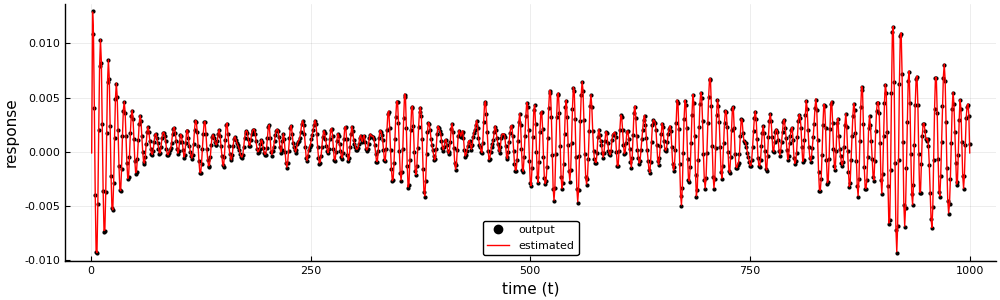

In [10]:
# Extract mean of state marginals
estimated_states = params_z[1][1,1:end]

# Plot every n-th time-point to avoid figure size exploding
n = 1
p1 = scatter(2:n:T, output[2:n:T], color="black", label="output", markersize=2, size=(1000,300), xlabel="time (t)", ylabel="response")
plot!(1:n:T, estimated_states[2:n:T], color="red", linewidth=1, label="estimated")
#     Plots.savefig(p1, "viz/estimated_states01.png")

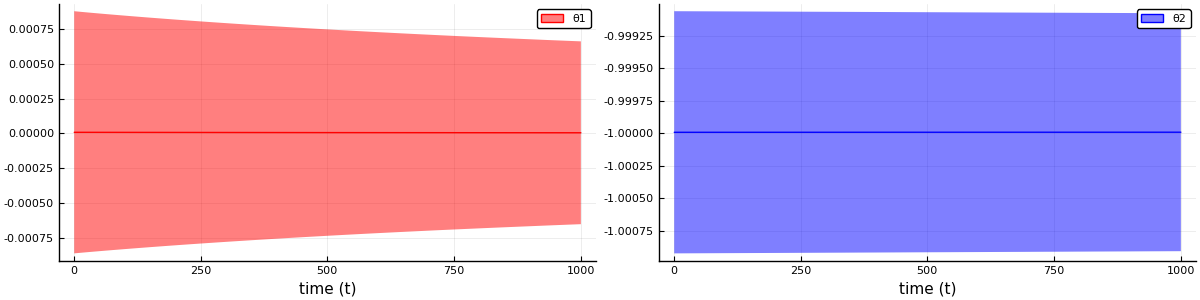

In [11]:
# Extract mean of coefficient marginals
estimated_coeffs_1_mean = params_θ[1][1,2:end]
estimated_coeffs_1_std = sqrt.(inv.(params_θ[2][1,1,2:end]))
estimated_coeffs_2_mean = params_θ[1][2,2:end]
estimated_coeffs_2_std = sqrt.(inv.(params_θ[2][2,2,2:end]))

# Plot both coefficients next to each other
p2a = plot(1:n:T, estimated_coeffs_1_mean[1:n:T], ribbon=[estimated_coeffs_1_std[1:n:T], estimated_coeffs_1_std[1:n:T]], color="red", label="θ1", xlabel="time (t)")
p2b = plot(1:n:T, estimated_coeffs_2_mean[1:n:T], ribbon=[estimated_coeffs_2_std[1:n:T], estimated_coeffs_2_std[1:n:T]], color="blue", label="θ2", xlabel="time (t)")
p2 = plot(p2a, p2b, size=(1200,300))
#     Plots.savefig(p2, "viz/estimated_coeffs.png")

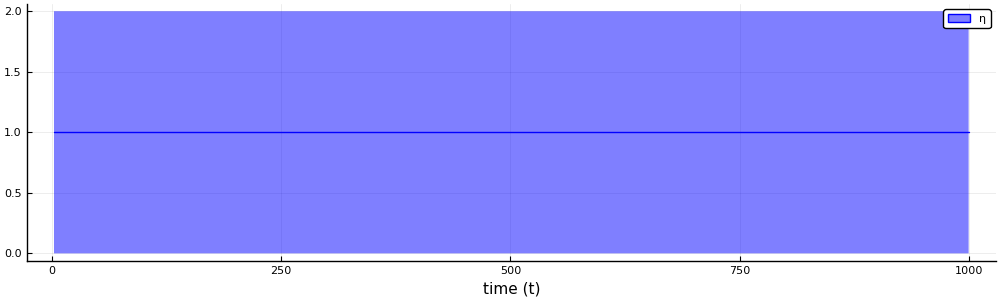

In [12]:
# Extract mean of control coefficient marginals
estimated_ccoeff_mean = params_η[1][1,1:end]
estimated_ccoeff_std = sqrt.(inv.(params_η[2][1,1:end]))

# Plot both coefficients next to each other
p3 = Plots.plot(2:n:T, estimated_ccoeff_mean[2:n:T], ribbon=[estimated_ccoeff_std[2:n:T], estimated_ccoeff_std[2:n:T]], color="blue", label="η", xlabel="time (t)", size=(1000,300))
#     Plots.savefig(p3, "viz/estimated_ccoeff.png")

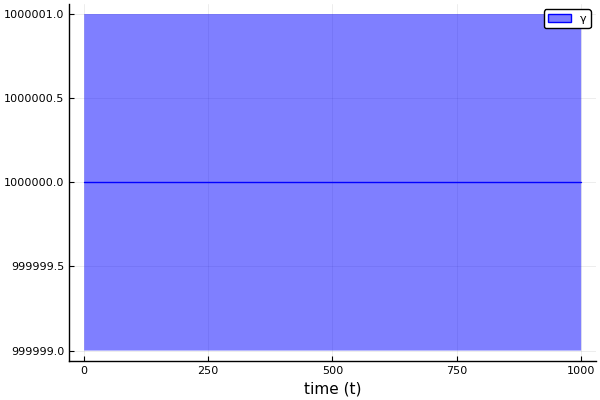

In [13]:
# Extract mean of process precision marginals
estimated_pnoise_mean = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
estimated_pnoise_std = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

# Plot both coefficients next to each other
p4 = Plots.plot(1:n:T, estimated_pnoise_mean[1:n:T], ribbon=[estimated_pnoise_std[1:n:T], estimated_pnoise_std[1:n:T]],color="blue", label="γ", xlabel="time (t)")
#     Plots.savefig(p4, "viz/estimated_pnoise.png")

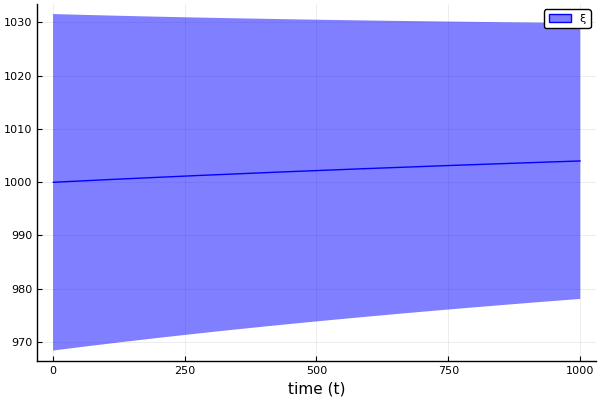

In [14]:
# Extract mean of process precision marginals
estimated_mnoise_mean = params_ξ[1][1,2:end] ./ params_ξ[2][1,2:end]
estimated_mnoise_std = sqrt.(params_ξ[1][1,2:end] ./ params_ξ[2][1,2:end].^2)

# Plot both coefficients next to each other
p4 = Plots.plot(1:n:T, estimated_mnoise_mean[1:n:T], ribbon=[estimated_mnoise_std[1:n:T], estimated_mnoise_std[1:n:T]],color="blue", label="ξ", xlabel="time (t)")
#     Plots.savefig(p4, "viz/estimated_pnoise.png")